In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# ***** LOAD DATAFRAME *****

path = "C:/Users/Aleksi/ownCloud/Vaasan Yliopisto/Gradu/Python codes/FIN/New_version/"
df = pd.read_csv(filepath_or_buffer=path+'df.txt')

print('Bankrupt:',np.sum(df['status']==1),'Healthy:',np.sum(df['status']==0), 'out of', len(df), 2*'\n',
      'Size:',df.shape)

b = df['status']==1 # mask for bankrupt
h = df['status']==0 # mask for healthy/active

Bankrupt: 2602 Healthy: 95056 out of 97658 

 Size: (97658, 17)


## Firm specific variables

In [5]:
# ****** RETAINED EARNINGS ****** 

# ret_earn = shareholdeers funds - capital - other shareholders funds - P/L for period

# t=0
df['ret_earn'] = (df['Shareholders funds EUR Last avail. yr'] - 
                  df['Capital EUR Last avail. yr'] -
                  df['Other shareholders funds EUR Last avail. yr'] - 
                  df['P/L for period [=Net income] EUR Last avail. yr'])




# ****** BOOK VALUE ******

# bv = total assets (tot.shareh.funds&liab.) - intangible fixed ass. - tot.liab.

df['bv'] = (df['Total assets EUR Last avail. yr'] - 
            df['Intangible fixed assets EUR Last avail. yr'] - 
            df['tot_liab'])



# ****** Z-SCORE VARIABLES ******
#           x1 x2 x3 x4

df['X1'] = df.loc[:,'Working capital EUR Last avail. yr']/df.loc[:,'Total assets EUR Last avail. yr']
df['X2'] = df.loc[:,'ret_earn']/df.loc[:,'Total assets EUR Last avail. yr']
df['X3'] = df.loc[:,'Operating P/L [=EBIT] EUR Last avail. yr']/df.loc[:,'Total assets EUR Last avail. yr']
df['X4'] = df.loc[:,'bv']/df.loc[:,'tot_liab']


## Macro economic variables

In [6]:
macro_path = "C:/Users/Aleksi/ownCloud/Vaasan Yliopisto/Gradu/Raw Data/Macro Data/"

#### GDP (change %)

In [7]:
# import data
gdp = pd.read_csv(filepath_or_buffer=macro_path+'GDP (eurostat)/nama_10_gdp_1_Data.csv', na_values=[':',''] )

# keep only necessary data
gdp = gdp.loc[gdp['UNIT']=='Chain linked volumes (2010), million euro',['TIME','UNIT','Value']]
gdp.dropna(inplace=True)

gdp.reset_index(inplace=True, drop=True)

# modify blank space in string and change to numeric
gdp['Value'] = gdp['Value'].str.replace(" ","")
gdp['Value'] = pd.to_numeric(gdp['Value'])

# add two columns: lagged and % change 
gdp['lagged -1'] = gdp['Value'].shift(periods=1)
gdp['change %'] = ((gdp['Value']/gdp['lagged -1'])-1)*100


print('Deleting year == 2020 leaves out',(df['Last avail. year']== 2020).sum(), 
      'observations where bankrupt',
      ((df['Last avail. year']== 2020)&(df['status']== 1)).sum())

# 2020 GDP not known --> so need to delete corresponding rows from df
df = df.loc[(df['Last avail. year']!= 2020), :]

# make a dictionary for mapping and map
gdp_dict = (gdp.loc[:,['TIME','change %']]).set_index('TIME').to_dict()

# add new column 'GDP change %' to df 
df['GDP change %'] = list(map(lambda x: gdp_dict['change %'][x], df['Last avail. year']))


Deleting year == 2020 leaves out 659 observations where bankrupt 7


#### Household debt & Interest as proportion usable income (%)

In [8]:
# household debt & interest are a percentage(%) of usable income (=Finnish definition)
hh_debt_int = pd.read_csv(filepath_or_buffer=macro_path+'Household debt and interest/Household debt and interest.csv',
                         delimiter = ';')
hh_debt_int.dropna(inplace=True)

# change the column names
hh_debt_int.columns = ['Date','Household debt %','Household interest %']

# distinguish the years --> list
hh_debt_int['Date'] = hh_debt_int['Date'].str.split('.')

# remove dates, leave 'Date' as int
for i in range(len(hh_debt_int['Date'])):
    hh_debt_int['Date'][i] = int(hh_debt_int['Date'][i][2])

# remove whitespaces
hh_debt_int.loc[:,'Household debt %'] = hh_debt_int.loc[:,'Household debt %'].str.strip()
hh_debt_int.loc[:,'Household interest %'] = hh_debt_int.loc[:,'Household interest %'].str.strip()

# replace ',' with '.' and change to numeric  
hh_debt_int['Household debt %'] = pd.to_numeric(hh_debt_int['Household debt %'].str.replace(',','.'))
hh_debt_int['Household interest %'] = pd.to_numeric(hh_debt_int['Household interest %'].str.replace(',','.'))  
    
# take average of quarters 
hh_debt_int = hh_debt_int.groupby(['Date']).mean()

# make dictionary
hh_dict = (hh_debt_int.loc[:,['Household debt %','Household interest %']]).to_dict()

# add new column 'Household debt %' and 'Household interest %'(map function) to df 
df['Household debt %'] = list(map(lambda x: hh_dict['Household debt %'][x], df['Last avail. year']))
df['Household interest %'] = list(map(lambda x: hh_dict['Household interest %'][x], df['Last avail. year']))


#### Money Supply (M3)

In [9]:
# ***** M3 MONEY SUPPLY *****

M3 = pd.read_csv(filepath_or_buffer=macro_path+'M3/M3.csv', sep=',' )

# extract the year and remove unnecessary values
M3 = M3.iloc[:,0].str.split(',', expand=True)
M3 = M3.iloc[:,[0,3]]
M3.iloc[:,0] = M3.iloc[:,0].str.split('-')

for i in range(len(M3)):
    
    M3.iloc[i,0] = M3.iloc[i,0][0]

M3.iloc[:,0] = pd.to_numeric(M3.iloc[:,0])
M3.iloc[:,1] = pd.to_numeric(M3.iloc[:,1])

# calculate the yearly change
M3.columns = ['Year','M3 supply']
M3 = M3.groupby(['Year']).mean()

M3['change %'] = ((M3.loc[:,'M3 supply'])/(M3['M3 supply'].shift(periods=1))-1)*100
M3['change % -1'] = M3['change %'].shift(periods=1)

M3_dict = (M3.loc[:,'change %']).to_dict()
M3_dict_1 = (M3.loc[:,'change % -1']).to_dict()

df = df [df['Last avail. year']>= 1999]  # no M3 data before 1999!
df['M3'] = list(map(lambda x: M3_dict[x], df['Last avail. year']))
df['M3 -1'] = list(map(lambda x: M3_dict_1[x], df['Last avail. year'])) # NA !!!

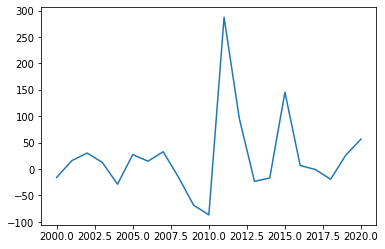

In [10]:
plt.plot(*zip(*M3_dict.items()))
plt.show()

In [11]:
# save df as 'df2.txt' csv-file
df.to_csv('df2.txt')